## Mount Google Drive

In [ ]:
from google.colab import drive

# see https://colab.research.google.com/notebooks/io.ipynb#scrollTo=RWSJpsyKqHjH
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Get Data

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
dataDir = '/content/drive/MyDrive/Deep Learning/data/archive/'

In [ ]:
# Get the data for the K-49 dataset
k49_classmap_path = os.path.join(dataDir, 'k49_classmap.csv')
k49_classmap = pd.read_csv(k49_classmap_path)
k49_classmap.dataframeName = 'k49_classmap.csv'
nRow, nCol = k49_classmap.shape
print(f'There are {nRow} rows and {nCol} columns')

k49_classmap.head()

There are 49 rows and 3 columns


,index,codepoint,char
0,0,U+3042,あ
1,1,U+3044,い
2,2,U+3046,う
3,3,U+3048,え
4,4,U+304A,お


## Prepare Datasets

In [ ]:
SEED = 444

learning_rate = 0.001

image_dim = 28
input_shape = (image_dim, image_dim, 1)

batch_size = 128
epochs = 25

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

# Paths
k49_train_images_path = os.path.join(dataDir, 'k49-train-imgs.npz')
k49_train_labels_path = os.path.join(dataDir, 'k49-train-labels.npz')
k49_test_images_path = os.path.join(dataDir, 'k49-test-imgs.npz')
k49_test_labels_path = os.path.join(dataDir, 'k49-test-labels.npz')

# Data loading
train_images = np.load(k49_train_images_path)['arr_0']
train_labels = np.load(k49_train_labels_path)['arr_0']
test_images = np.load(k49_test_images_path)['arr_0']
test_labels = np.load(k49_test_labels_path)['arr_0']

num_classes = len(np.unique(train_labels))

print("Classes:", num_classes)
print(f"Number of training samples: {len(train_images)} where each sample is of size: {train_images.shape[1:]}")
print(f"Number of test samples: {len(test_images)} where each sample is of size: {test_images.shape[1:]}")

Classes: 49
Number of training samples: 232365 where each sample is of size: (28, 28)
Number of test samples: 38547 where each sample is of size: (28, 28)


## Plot Data

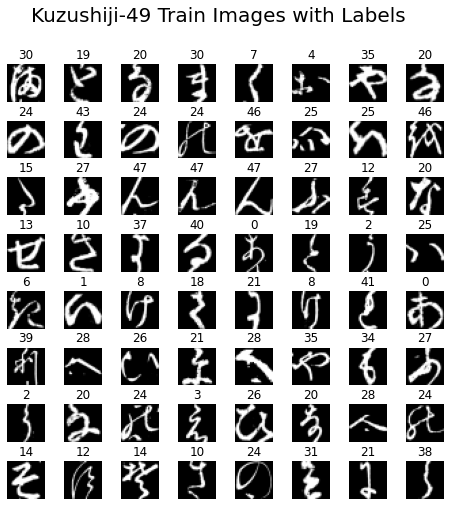

In [ ]:
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(8, 8))
fig.suptitle('Kuzushiji-49 Train Images with Labels', fontsize=20)

for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(train_images[i], cmap='gray')
    ax.set_title(train_labels[i])
    ax.axis('off')

plt.subplots_adjust(hspace=0.5)
plt.savefig('/content/drive/MyDrive/Deep Learning/training_images_49.png')
plt.savefig('/content/drive/MyDrive/Deep Learning/training_images_49.jpg')
plt.savefig('/content/drive/MyDrive/Deep Learning/training_images_49.svg')
plt.savefig('/content/drive/MyDrive/Deep Learning/training_images_49.pdf')
plt.show()

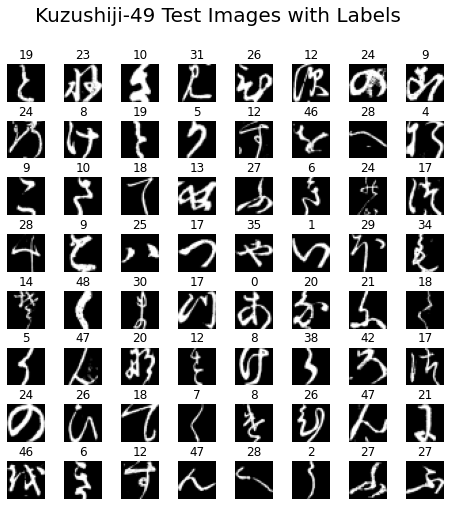

In [ ]:
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, figsize=(8, 8))
fig.suptitle('Kuzushiji-49 Test Images with Labels', fontsize=20)

for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(test_images[i], cmap='gray')
    ax.set_title(test_labels[i])
    ax.axis('off')

plt.subplots_adjust(hspace=0.5)
plt.savefig('/content/drive/MyDrive/Deep Learning/test_images_49.png')
plt.savefig('/content/drive/MyDrive/Deep Learning/test_images_49.jpg')
plt.savefig('/content/drive/MyDrive/Deep Learning/test_images_49.svg')
plt.savefig('/content/drive/MyDrive/Deep Learning/test_images_49.pdf')
plt.show()

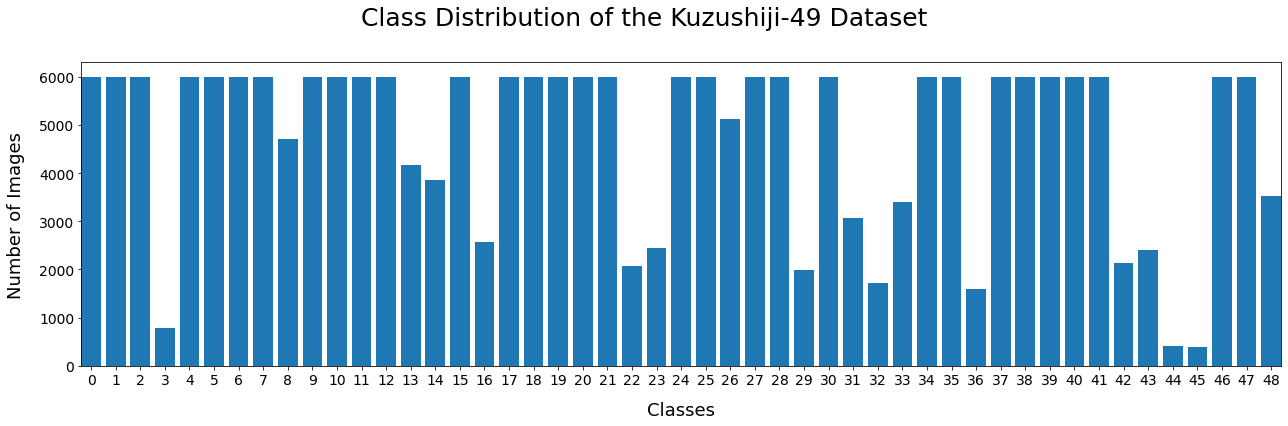

In [ ]:
# Plot the data repartition between all classes
k49_train_labels = pd.Series(train_labels)
k49_train_labels_values = k49_train_labels.value_counts(sort=False).sort_index()
fig, ax = plt.subplots(figsize=(18,6))
fig.suptitle('Class Distribution of the Kuzushiji-49 Dataset', fontsize=25)
ax.bar(k49_train_labels_values.index, k49_train_labels_values.values)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.margins(x=0.001)
plt.subplots_adjust(bottom=0.2)
plt.margins(x=0)
ax.set_xticks(k49_train_labels_values.index)
ax.set_xlabel('Classes', fontsize=18, labelpad=14)
ax.set_ylabel('Number of Images', fontsize=18, labelpad=14)
fig.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('/content/drive/MyDrive/Deep Learning/class_distribution_49.png', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Deep Learning/class_distribution_49.jpg', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Deep Learning/class_distribution_49.svg', bbox_inches='tight')
plt.savefig('/content/drive/MyDrive/Deep Learning/class_distribution_49.pdf', bbox_inches='tight')
plt.show()

#k49_train_labels_values.plot.bar(figsize=(15,4))

## Preprocessing Data

In [ ]:
# Using expand_dims to get a nominal deep learning format for all images
# (28, 28) --> (28, 28, 1)
train_images = np.expand_dims(train_images, axis=-1)
test_images = np.expand_dims(test_images, axis=-1)

# Convert label vectors to matrices
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

# Split the train dataset in train and validation datasets
train_set, validation_set, train_labels, validation_labels = train_test_split(train_images, train_labels, test_size=0.10)

# Normalize the datasets
train_set = train_set.reshape(train_set.shape[0], train_set.shape[1], train_set.shape[2], 1)/255
validation_set = validation_set.reshape(validation_set.shape[0], validation_set.shape[1], validation_set.shape[2], 1)/255
test_set = test_images.reshape(test_images.shape[0], test_images.shape[1], test_images.shape[2], 1)/255

# Dimensions of the datasets
print(f"""
Train set dimensions: {train_set.shape}
Validation set dimensions: {validation_set.shape}
Test set dimensions: {test_set.shape}
""")

## Build and Train Model

In [ ]:
# Define a CNN model
model = Sequential()

model.add(Conv2D(32, (5, 5), strides=(1, 1), activation='relu', input_shape=input_shape))

model.add(Conv2D(32, (5, 5), strides=(2, 2), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))

model.add(Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Conv2D(96, (3, 3), strides=(1, 1), activation='relu'))

model.add(Conv2D(96, (3, 3), strides=(1, 1), activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate), loss=categorical_crossentropy, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 24, 24, 32)        832       
                                                                 
 conv2d_7 (Conv2D)           (None, 10, 10, 32)        25632     
                                                                 
 batch_normalization_3 (Batc  (None, 10, 10, 32)       128       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 10, 10, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 6, 6, 64)          36928     
                                                      

In [ ]:
history = model.fit(train_set, train_labels, epochs=epochs, validation_data=(validation_set, validation_labels), batch_size=batch_size)

Epoch 1/25
1634/1634 [==============================] - 13s 7ms/step - loss: 0.7459 - accuracy: 0.7949 - val_loss: 0.2925 - val_accuracy: 0.9196
Epoch 2/25
1634/1634 [==============================] - 12s 7ms/step - loss: 0.3075 - accuracy: 0.9114 - val_loss: 0.2129 - val_accuracy: 0.9410
Epoch 3/25
1634/1634 [==============================] - 12s 8ms/step - loss: 0.2441 - accuracy: 0.9302 - val_loss: 0.2078 - val_accuracy: 0.9428
Epoch 4/25
1634/1634 [==============================] - 12s 7ms/step - loss: 0.2106 - accuracy: 0.9395 - val_loss: 0.1822 - val_accuracy: 0.9512
Epoch 5/25
1634/1634 [==============================] - 12s 7ms/step - loss: 0.1885 - accuracy: 0.9458 - val_loss: 0.1573 - val_accuracy: 0.9561
Epoch 6/25
1634/1634 [==============================] - 12s 7ms/step - loss: 0.1729 - accuracy: 0.9506 - val_loss: 0.1727 - val_accuracy: 0.9535
Epoch 7/25
1634/1634 [==============================] - 12s 7ms/step - loss: 0.1591 - accuracy: 0.9539 - val_loss: 0.1586 - val_ac

## Evaluate Model

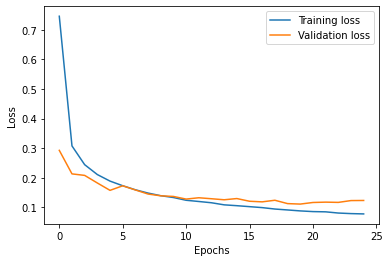

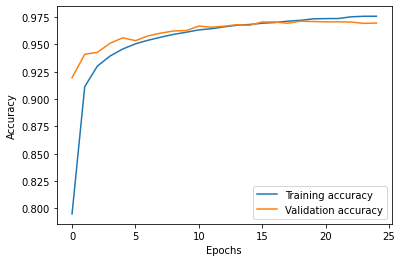

In [ ]:
history = history.history
plt.plot(history['loss'], label = 'Training loss')
plt.plot(history['val_loss'], label = 'Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history['accuracy'], label = 'Training accuracy')
plt.plot(history['val_accuracy'], label = 'Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
print("Evaluate model on test data")
results = model.evaluate(test_images, test_labels, batch_size=batch_size)
print("Test loss: {:.4f}".format(results[0]))
print("Test accuracy: {:.4f}".format(results[1]))

Evaluate model on test data
302/302 [==============================] - 1s 4ms/step - loss: 0.2164 - accuracy: 0.9529
Test loss: 0.2164
Test accuracy: 0.9529


## Show 100 Random Output Samples

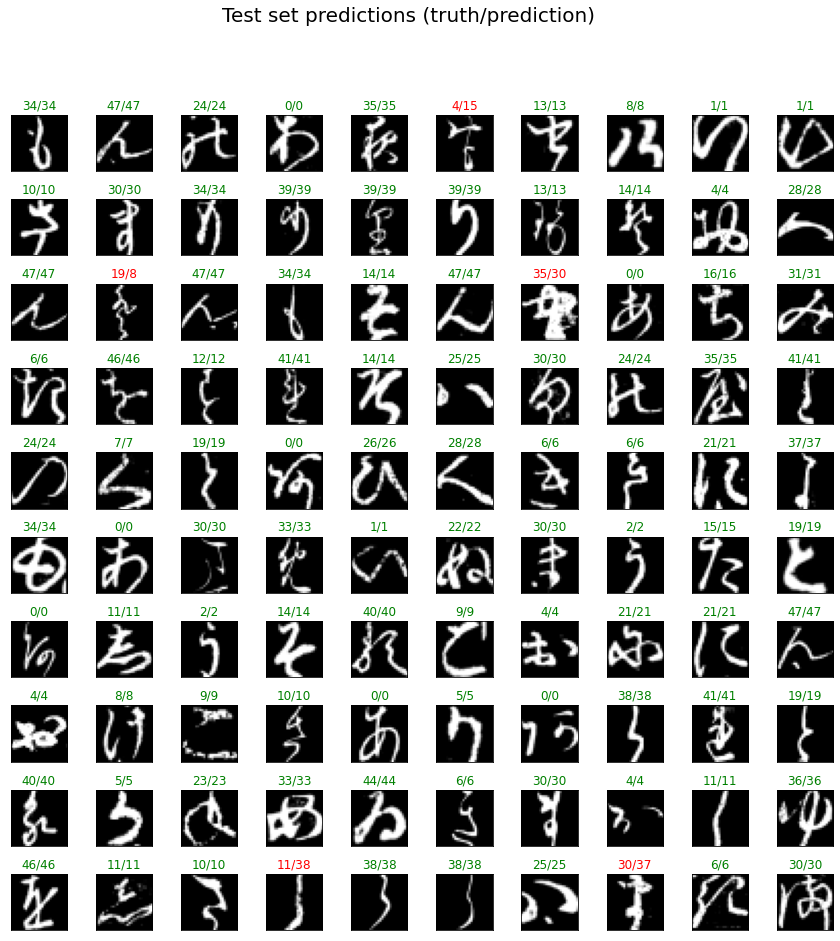

In [ ]:
# Generate 100 random output predictions
random_idx = np.random.randint(0, test_images.shape[0], 100)

random_set = test_images[random_idx]
random_labels = test_labels[random_idx].argmax(axis=1).reshape(10, 10)
pred_labels = model.predict(random_set).argmax(axis=1).reshape(10, 10)

random_set = random_set.reshape(10, 10, image_dim, image_dim)

# Create 10x10 grid
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
fig.suptitle('Test set predictions (truth/prediction)', fontsize=20)

for i in range(random_set.shape[0]):
    for j in range(random_set.shape[1]):
        example = random_set[i, j]
        ax[i, j].imshow(example, cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        color = ('green' if random_labels[i, j] == pred_labels[i, j] else 'red')
        ax[i, j].set_title(f"{random_labels[i, j]}/{pred_labels[i, j]}", color=color)

plt.subplots_adjust(hspace=0.5)
plt.show()